In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import load_img
from keras.optimizers import Adam
from keras import Model
from skimage import measure
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout

In [ ]:
!unzip /content/drive/MyDrive/kmc_segmentation.zip

In [ ]:
images = "/content/kmc_segmentation/image"
masks = "/content/kmc_segmentation/label"
image_height = 256
image_width = 256
IMG_IDS = next(os.walk(images))[2]
#Storing all file names from DATA_IMAGES in IMG_IDS
print(f"No of images in the dataset: {len(IMG_IDS)}")

No of images in the dataset: 3334


In [ ]:
X = np.zeros((len(IMG_IDS), image_height, image_width, 1), dtype=np.float32)
y = np.zeros((len(IMG_IDS), image_height, image_width, 1), dtype=np.float32)
#X and y will be used to store the input images and masks respectively

In [ ]:
'''def create_labelled_dataset():

    for n, ids in enumerate(IMG_IDS):
        img = load_img(os.path.join(images, ids))
        x_img_arr = np.asarray((img))
        x_img = resize(x_img_arr, (image_height,image_width, 3), mode='constant', preserve_range=True)
        x_img = rgb2gray(x_img)
        x_img = np.expand_dims(x_img, axis=-1)

        mask  = load_img(os.path.join(masks, ids))
        y_mask_arr = np.asarray(mask)
        y_mask = resize(y_mask_arr, (image_height, image_width, 3), mode='constant', preserve_range=True)
        y_mask = rgb2gray(y_mask)
        y_mask = np.expand_dims(y_mask, axis=-1)

        X[n] = x_img/255.0
        y[n] = y_mask/255.0

    return X, y'''

In [ ]:
!pip install tifffile
!pip install imagecodecs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 46.4 MB/s eta 0:00:00


In [ ]:
import imagecodecs
import tifffile

In [ ]:
def create_labelled_dataset():
    for n, ids in enumerate(IMG_IDS):
        img = tifffile.imread(os.path.join(images, ids))
        x_img_arr = np.asarray((img))
        x_img = resize(x_img_arr, (image_height,image_width, 3), mode='constant', preserve_range=True)
        x_img = rgb2gray(x_img)
        x_img = np.expand_dims(x_img, axis=-1)

        mask  = tifffile.imread(os.path.join(masks, ids))
        y_mask_arr = np.asarray(mask)
        y_mask = resize(y_mask_arr, (image_height, image_width, 3), mode='constant', preserve_range=True)
        y_mask = rgb2gray(y_mask)
        y_mask = np.expand_dims(y_mask, axis=-1)

        X[n] = x_img/255.0
        y[n] = y_mask/255.0
    return X, y

In [ ]:
'''def create_labelled_dataset():

    for n, img_filename in enumerate(IMG_IDS):
        img = tifffile.imread(os.path.join(images, img_filename))
        x_img_arr = np.asarray(img)
        x_img = resize(x_img_arr, (image_height,image_width, 3), mode='constant', preserve_range=True)
        x_img = rgb2gray(x_img)
        x_img = np.expand_dims(x_img, axis=-1)

        mask_filename_prefix = os.path.splitext(img_filename)[0]
        mask_filenames = [f for f in os.listdir(masks) if f.startswith(mask_filename_prefix)]
        mask_filename = mask_filenames[0]

        mask = tifffile.imread(os.path.join(masks, mask_filename))
        y_mask_arr = np.asarray(mask)
        y_mask = resize(y_mask_arr, (image_height, image_width, 3), mode='constant', preserve_range=True)
        y_mask = rgb2gray(y_mask)
        y_mask = np.expand_dims(y_mask, axis=-1)

        X[n] = x_img/255.0
        y[n] = y_mask/255.0

    return X, y'''

"def create_labelled_dataset():\n\n    for n, img_filename in enumerate(IMG_IDS):\n        img = tifffile.imread(os.path.join(images, img_filename))\n        x_img_arr = np.asarray(img)\n        x_img = resize(x_img_arr, (image_height,image_width, 3), mode='constant', preserve_range=True)\n        x_img = rgb2gray(x_img)\n        x_img = np.expand_dims(x_img, axis=-1)\n        \n        mask_filename_prefix = os.path.splitext(img_filename)[0] \n        mask_filenames = [f for f in os.listdir(masks) if f.startswith(mask_filename_prefix)] \n        mask_filename = mask_filenames[0] \n        \n        mask = tifffile.imread(os.path.join(masks, mask_filename))\n        y_mask_arr = np.asarray(mask)\n        y_mask = resize(y_mask_arr, (image_height, image_width, 3), mode='constant', preserve_range=True)\n        y_mask = rgb2gray(y_mask)\n        y_mask = np.expand_dims(y_mask, axis=-1) \n        \n        X[n] = x_img/255.0 \n        y[n] = y_mask/255.0\n        \n    return X, y"

In [ ]:
X, y = create_labelled_dataset()

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(2667, 256, 256, 1)
(2667, 256, 256, 1)
(667, 256, 256, 1)
(667, 256, 256, 1)


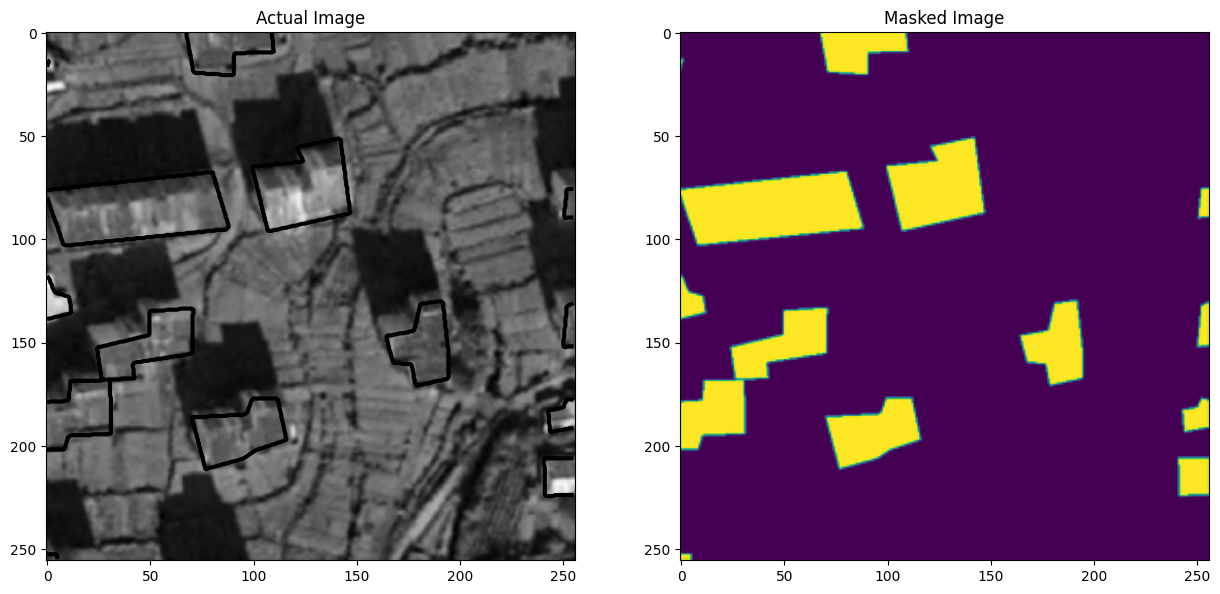

In [ ]:
def plot_sample_examplee(ix):
    has_mask = y_train[ix].max() > 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

    ax1.imshow(X_train[ix], cmap='gray', interpolation = 'bilinear')

    ax1.contour(y_train[ix].squeeze(), colors = 'black', linewidths = 3, levels = [0.5])
    ax1.set_title('Actual Image')

    ax2.imshow(y_train[ix].squeeze(), interpolation = 'bilinear')
    ax2.set_title('Masked Image')

plot_sample_examplee(25)

In [ ]:
def Conv2D_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
              kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
               kernel_initializer='he_normal', padding='same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def unet(input_image, n_filters=16, kernel_size=3, dropout=0.1, batchnorm=True):
    #Encoder
    c1 = Conv2D_block(input_image, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = Conv2D_block(p1, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = Conv2D_block(p2, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = Conv2D_block(p3, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = Conv2D_block(p4, n_filters * 16, kernel_size = kernel_size, batchnorm = batchnorm)

    # Decoder
    u6 = Conv2DTranspose(n_filters * 8, (kernel_size, kernel_size), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = Conv2D_block(u6, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (kernel_size, kernel_size), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = Conv2D_block(u7, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (kernel_size, kernel_size), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = Conv2D_block(u8, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters, (kernel_size, kernel_size), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = Conv2D_block(u9, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)

    output = Conv2D(1, (1,1), activation='sigmoid')(c9)
    model = Model(inputs=[input_image], outputs=[output])
    return model

In [ ]:
input_img = Input((image_height, image_width, 1), name='img')
model = unet(input_img, n_filters=16, kernel_size=3, dropout=0.01, batchnorm=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
167/167 [==============================] - 64s 277ms/step - loss: 0.3078 - accuracy: 0.8704 - val_loss: 0.4109 - val_accuracy: 0.8713
Epoch 2/100
167/167 [==============================] - 43s 257ms/step - loss: 0.1894 - accuracy: 0.8929 - val_loss: 0.1821 - val_accuracy: 0.9041
Epoch 3/100
167/167 [==============================] - 43s 257ms/step - loss: 0.1601 - accuracy: 0.8946 - val_loss: 0.1503 - val_accuracy: 0.9010
Epoch 4/100
167/167 [==============================] - 44s 263ms/step - loss: 0.1442 - accuracy: 0.8961 - val_loss: 0.1391 - val_accuracy: 0.9008
Epoch 5/100
167/167 [==============================] - 44s 264ms/step - loss: 0.1336 - accuracy: 0.8966 - val_loss: 0.1170 - val_accuracy: 0.8999
Epoch 6/100
167/167 [==============================] - 44s 266ms/step - loss: 0.1277 - accuracy: 0.8973 - val_loss: 0.1608 - val_accuracy: 0.9051
Epoch 7/100
167/167 [==============================] - 44s 266ms/step - loss: 0.1217 - accuracy: 0.8977 - val_loss: 0.1178 -

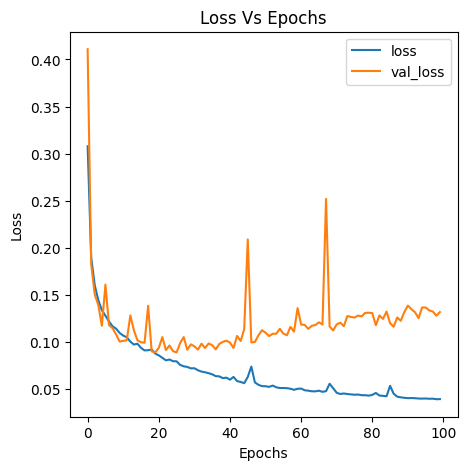

In [ ]:
def plot_history(results):
    plt.figure(figsize=(5,5))
    plt.title("Loss Vs Epochs")
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

plot_history(history)

In [ ]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

21/21 [==============================] - 5s 239ms/step


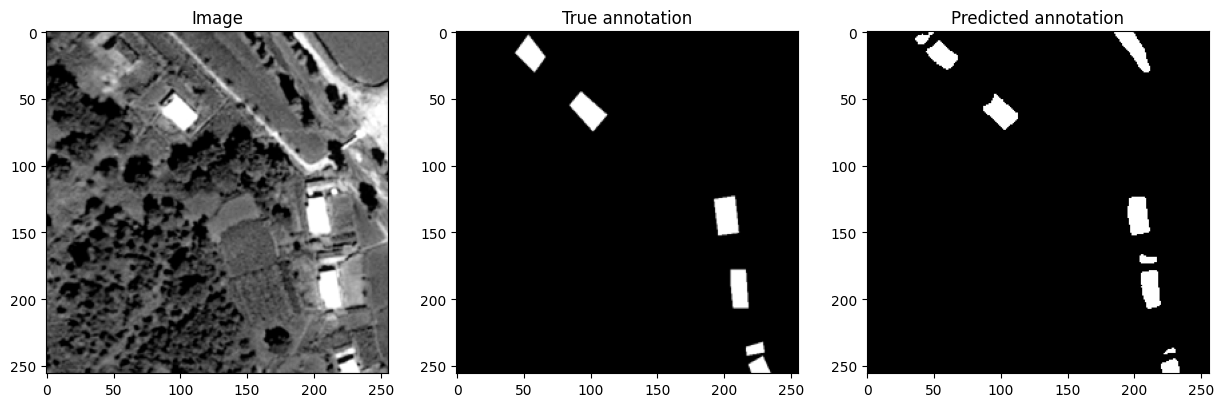

In [ ]:
def plot_sample_resultt(X, y, binary_preds, ix):
    fig, ax = plt.subplots(1, 3, figsize=(15,7))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')

    ax[0].set_title('Image')

    ax[1].imshow(y[ix], cmap='gray')
    ax[1].set_title('True annotation')

    ax[2].imshow(binary_preds[ix].squeeze(), cmap='gray',vmin=0, vmax=1)
    ax[2].set_title('Predicted annotation')
plot_sample_resultt(X_valid, y_valid, preds_val_t,65)

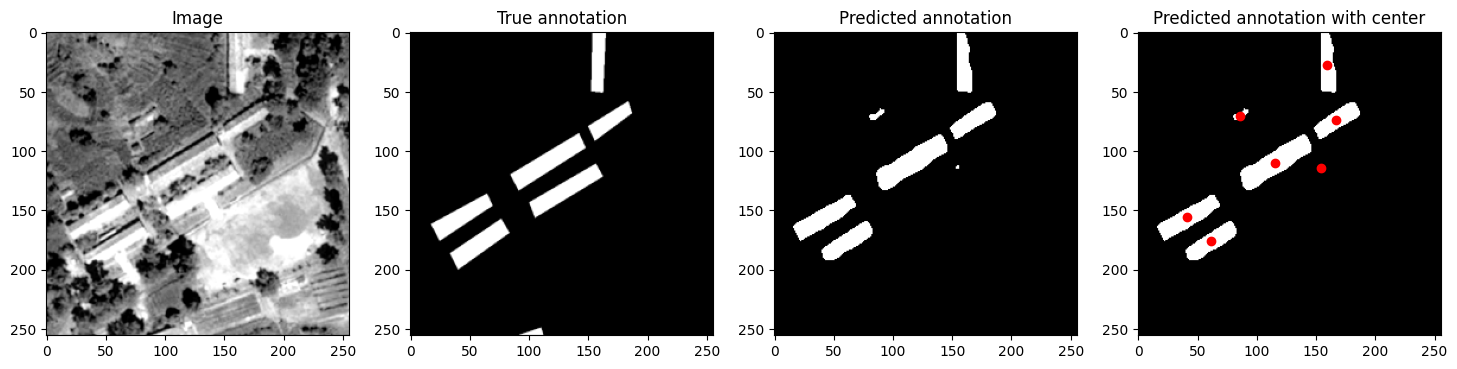

In [ ]:
def asd(X, y, binary_preds, ix):
    fig, ax = plt.subplots(1, 4, figsize=(18, 7))

    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].set_title('Image')

    ax[1].imshow(y[ix], cmap='gray')
    ax[1].set_title('True annotation')

    ax[2].imshow(binary_preds[ix].squeeze(), cmap='gray', vmin=0, vmax=1)
    ax[2].set_title('Predicted annotation')

    mask = binary_preds[ix].squeeze()
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    annotated_img = np.copy(binary_preds[ix].squeeze())

    for contour in contours:
        M = cv2.moments(contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroid = (cX, cY)

        annotated_img[cY, cX] = 1
        ax[3].plot(cX, cY, 'ro')

    ax[3].imshow(annotated_img, cmap='gray', vmin=0, vmax=1)
    ax[3].set_title('Predicted annotation with center')

    plt.show()
asd(X_valid, y_valid, preds_val_t,20)

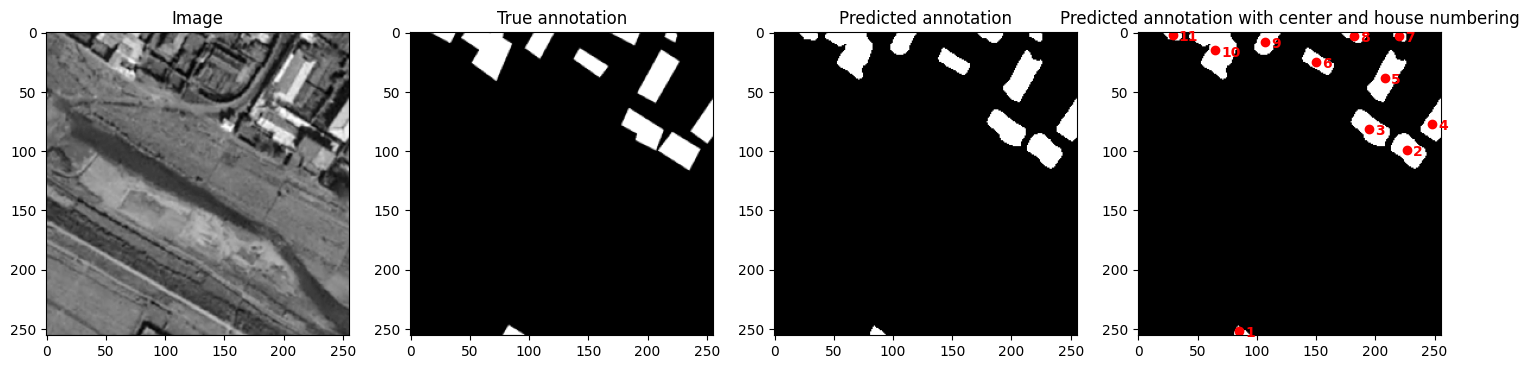

Number of houses predicted: 11


In [ ]:
def plot(X, y, binary_preds, ix):
    fig, ax = plt.subplots(1, 4, figsize=(18, 7))

    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].set_title('Image')

    ax[1].imshow(y[ix], cmap='gray')
    ax[1].set_title('True annotation')

    ax[2].imshow(binary_preds[ix].squeeze(), cmap='gray', vmin=0, vmax=1)
    ax[2].set_title('Predicted annotation')

    mask = binary_preds[ix].squeeze()
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    annotated_img = np.copy(binary_preds[ix].squeeze())

    house_count = 0

    for i, contour in enumerate(contours):
        M = cv2.moments(contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroid = (cX, cY)

        annotated_img[cY, cX] = 1
        ax[3].plot(cX, cY, 'ro')

        house_count += 1
        ax[3].text(cX + 5, cY + 5, str(house_count), color='red', fontsize=10, fontweight='bold')

    ax[3].imshow(annotated_img, cmap='gray', vmin=0, vmax=1)
    ax[3].set_title('Predicted annotation with center and house numbering')

    plt.show()

    print("Number of houses predicted:", house_count)
plot(X_train, y_train, preds_train_t,65)

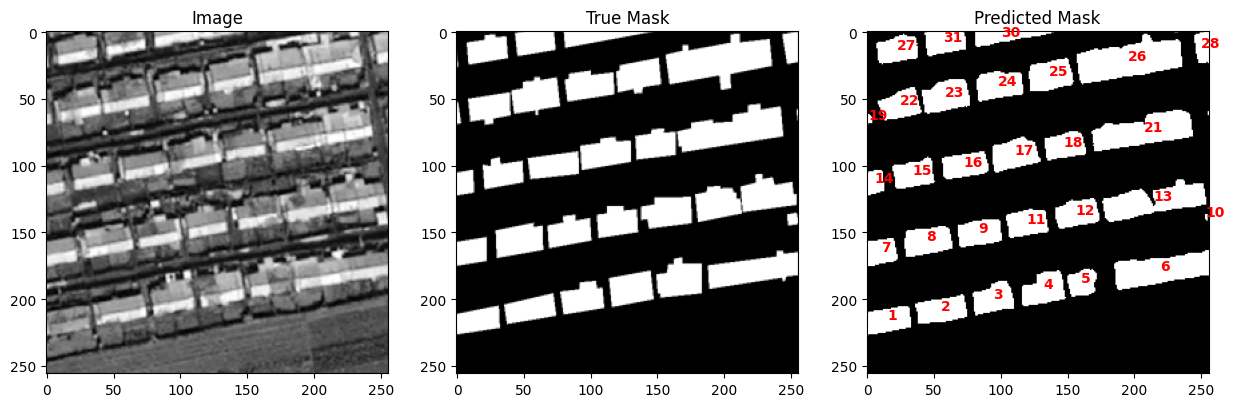

In [ ]:
def plot3(X, y, binary_preds, ix):
    fig, ax = plt.subplots(1, 3, figsize=(15, 7))

    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].set_title('Image')

    ax[1].imshow(y[ix], cmap='gray')
    ax[1].set_title('True Mask')

    ax[2].imshow(binary_preds[ix].squeeze(), cmap='gray', vmin=0, vmax=1)
    ax[2].set_title('Predicted Mask')

    mask = binary_preds[ix].squeeze()
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for i, contour in enumerate(contours):
        M = cv2.moments(contour)
        if M["m00"] == 0:
            continue

        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        house_number = str(i + 1)
        ax[2].text(cX, cY, house_number, color='red', fontsize=10, fontweight='bold')

    plt.show()
plot3(X_valid, y_valid, preds_val_t,7)

In [ ]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('/content/drive/MyDrive/img1.png')

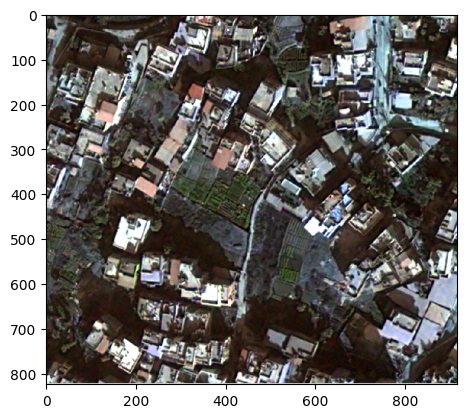

In [ ]:
plt.imshow(img)

1/1 [==============================] - 1s 683ms/step


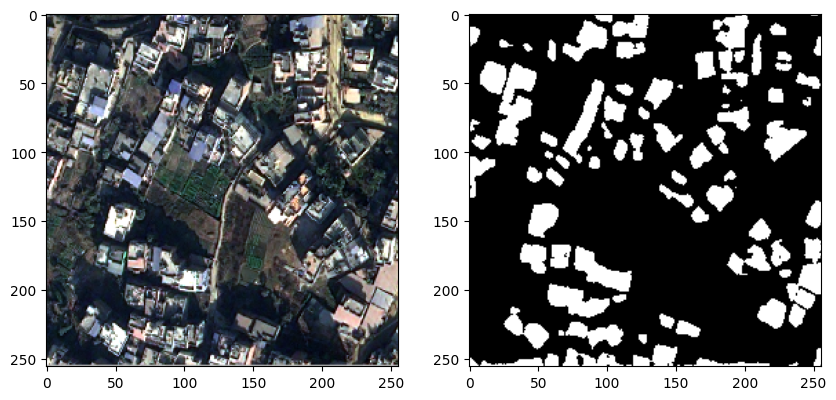

In [ ]:
test_image_resized = cv2.resize(img, (image_height, image_width))
test_image_gray = cv2.cvtColor(test_image_resized, cv2.COLOR_BGR2GRAY)
test_image_normalized = test_image_gray / 255.0
test_image_input = np.expand_dims(test_image_normalized, axis=-1)
test_image_input = np.expand_dims(test_image_input, axis=0)

predicted_mask = model.predict(test_image_input)

predicted_mask = predicted_mask.reshape(image_height, image_width)
predicted_mask_binary = np.where(predicted_mask > 0.5, 1, 0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(test_image_resized,cv2.COLOR_BGR2RGB))
ax[1].imshow(predicted_mask_binary,interpolation='bilinear',cmap='gray')
plt.show()

In [ ]:
def plot_predicted_mask_with_numbering(image, predicted_mask):
    image_height, image_width = predicted_mask.shape

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Image')

    ax[1].imshow(predicted_mask, cmap='gray')
    ax[1].set_title('Predicted Mask')

    predicted_mask_uint8 = np.uint8(predicted_mask * 255)

    contours, _ = cv2.findContours(predicted_mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for i, contour in enumerate(contours):
        M = cv2.moments(contour)
        if M["m00"] == 0:
            continue

        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        house_number = str(i + 1)
        ax[1].text(cX, cY, house_number, color='red', fontsize=10, fontweight='bold')

    plt.show()

In [ ]:
image_path = '/content/drive/MyDrive/img3.png'
img = cv2.imread(image_path)

image_height, image_width = 256, 256
test_image_resized = cv2.resize(img, (image_height, image_width))
test_image_gray = cv2.cvtColor(test_image_resized, cv2.COLOR_BGR2GRAY)
test_image_normalized = test_image_gray / 255.0
test_image_input = np.expand_dims(test_image_normalized, axis=-1)
test_image_input = np.expand_dims(test_image_input, axis=0)

predicted_mask = model.predict(test_image_input)
predicted_mask = predicted_mask.reshape(image_height, image_width)
predicted_mask_binary = np.where(predicted_mask > 0.5, 1, 0)

1/1 [==============================] - 1s 889ms/step


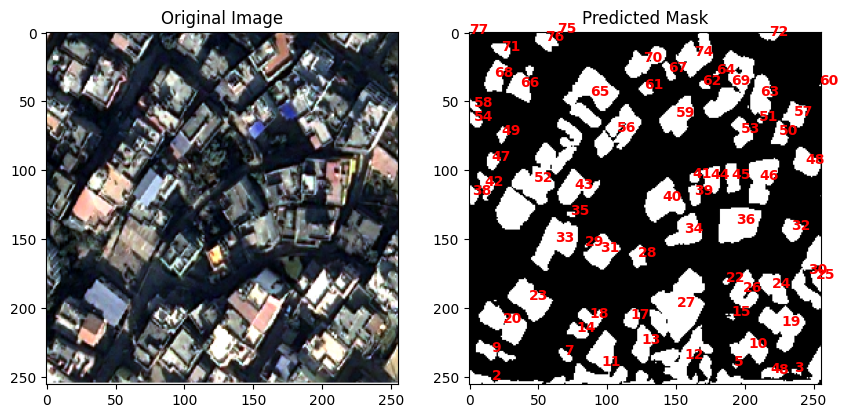

In [ ]:
plot_predicted_mask_with_numbering(test_image_resized, predicted_mask_binary)

In [ ]:
model.save('kmc_segmentation_model.h5')

In [ ]:
from keras.models import load_model

model_path = '/content/kmc_segmentation_model.h5'
model = load_model(model_path)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
tflite_model_path = '/content/kmc_segmentation_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)